In [1]:
# if you don't have any of these packages and you are using conda: type "conda install package" in terminal
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, log_loss
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.sparse import coo_matrix, hstack

# for tdidf
import pyspark.sql.functions as f
from transformers import BertTokenizer
#from transformers import BertModel
from pyspark.sql.functions import *
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

#import scipy.sparse
from scipy import sparse as sp

#For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# For baseline 
import keras 
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LeakyReLU
from keras.losses import BinaryCrossentropy

# For graph
import networkx as nx
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

# For testing
from sklearn.model_selection import train_test_split

# For modelling
from sklearn.metrics import precision_recall_curve, auc, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import PowerTransformer,RobustScaler

# For Evaluation
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

/Users/timi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data understanding

## Collect initial data 

**Task: Collect initial data**\
Acquire within the project the data (or access to the data) listed in the
project resources. This initial collection includes data loading if necessary
for data understanding. 

**Output: Initial data collection report**\
List 
* the **dataset** (or datasets) acquired 
* together with their **locations** within the project
* the **methods** used to acquire them
* and any **problems** encountered. 

In [2]:
file = 'training_sample.tsv'

column_names = ["text_tokens", 
                "hashtags", 
                "tweet_id", 
                "present_media", 
                "present_links", 
                "present_domains",
                "tweet_type", 
                "language", 
                "tweet_timestamp", 
                "engaged_with_user_id", 
                "engaged_with_user_follower_count",
                "engaged_with_user_following_count", 
                "engaged_with_user_is_verified", 
                "engaged_with_user_account_creation",
                "engaging_user_id", 
                "engaging_user_follower_count", 
                "engaging_user_following_count", 
                "engaging_user_is_verified",
                "engaging_user_account_creation", 
                "engaged_follows_engaging", 
                "reply_timestamp", "retweet_timestamp",
                "retweet_with_comment_timestamp", 
                "like_timestamp"]

df = pd.read_csv(file, header=None, names=column_names, delimiter='\x01')

## Describe data 

**Task: Describe data**\
Examine the “gross” or “surface” properties of the acquired data and
report on the results.

**Output: Data description report**\
Describe the data wich has been acquired, including: 
* the **format** of the data
* the **quantity** of data, for example number of records and fields in each table,
* the **identities** of the fields and any other surface features of the data which have been discovered. 

Does the data acquired satisfy the relevant requirements?

| Feature category    | Feature name                 | Feature dtype | Feature description                                                                           |
|---------------------|------------------------------|---------------|-----------------------------------------------------------------------------------------------|
|       | text_tokens                  |        |                              
| User features       | userId                       | string        | User identifier                                                                               |
| User features       | follower count               | int           | Number of followers of the user                                                               |
| User features       | following count              | int           | Number of accounts this user is following                                                     |
| User features       | is verified                  | bool          | Is the account verified?                                                                      |
| User features       | account creation             | timestamp     | in ms int Unix timestamp (in seconds) of the creation time of the account                     |
| Tweet features      | tweetId                      | string        | Tweet identifier                                                                              |
| Tweet features      | presentMedia                 | list[string]  | Tab-separated list of media types;  media type can be in (Photo, Video, Gif)                  |
| Tweet features      | presentLinks                 | list[string]  | Tab-separated list of links included in the tweet                                             |
| Tweet features      | presentDomains               | list[string]  | Tab-separated list of domains (e.g. twitter.com) included in the tweet                        |
| Tweet features      | tweetType                    | string        | Tweet type, can be either Retweet, Quote, Reply, or Toplevel                                  |
| Tweet features      | language                     | string        | Identifier corresponding to inferred language of the tweet                                    |
| Tweet features      | tweet timestamp              | int           | Unix timestamp, in seconds of the creation time of the Tweet                                  |
| Tweet features      | tweet tokens                 | list[int]     | Ordered list of Bert ids corresponding to Bert tokenization of Tweet text                     |
| Tweet features      | tweet hashtags               | list[string]  | Tab-separated list of hashtags present in the tweet                                           |
| Engagement features | reply engagement timestamp   | int           | Unix timestamp, in seconds, of the Reply engagement if one exists.                            |
| Engagement features | retweet engagement timestamp | int           | Unix timestamp, in seconds, of the Retweet engagement if one exists.                          |
| Engagement features | quote engagement timestamp   | int           | Unix timestamp, in seconds, of the Quote engagement if one exists.                            |
| Engagement features | like engagement timestamp    | int           | Unix timestamp, in seconds, of the Like engagement if one exists.                             |
| Engagement features | engageeFollowsEngager        | bool          | Does the account of the engaged tweet author follow the account that has made the engagement? |

To get a first feeling for the data the first 20 rows are printed below.

In [3]:
pd.set_option('display.max_columns', None)
print(df.shape)
display(df.head(20))

(80425, 24)


,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
0,101\t56898\t137\t174\t63247\t10526\t131\t3197\...,NaN,3C21DCFB8E3FEC1CB3D2BFB413A78220,Video,NaN,NaN,Retweet,76B8A9C3013AE6414A3E6012413CDC3B,1581467323,D1AA2C85FA644D64346EDD88470525F2,737,706,False,1403069820,000046C8606F1C3F5A7296222C88084B,131,2105,False,1573978269,False,NaN,NaN,NaN,NaN
1,101\t102463\t10230\t10105\t21040\t10169\t12811...,NaN,3D87CC3655C276F1771752081423B405,NaN,BB422AA00380E45F312FD2CAA75F4960,92D397F8E0F1E77B36B8C612C2C51E23,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580975391,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,1230139136,00006047187D0D18598EF12A650E1DAC,22,50,False,1340673962,False,NaN,NaN,NaN,NaN
2,101\t56898\t137\t11255\t22037\t10263\t168\t111...,DB32BD91C2F1B37BE700F374A07FBC61,3701848B96AA740528A2B0E247777D7D,NaN,2423BA02A75DB2189335DDC3FB6B74A1,6D323BE93766E79BE423FAC5C28BE39B,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581257232,5C671539CB41B9807E209349B101E9FF,988,167,False,1530094483,0000648BAA193AE4C625DDF789B57172,251,719,False,1456473671,False,NaN,NaN,NaN,NaN
3,101\t13073\t28757\t106\t100\t14120\t131\t120\t...,NaN,18176C6AD2871729384062F073CCE94D,Video,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581164292,70B900BE17416923D1E236A38798F202,1228134,5413,False,1378699943,000071667F50BAFEA722A8E8284581E5,18,58,False,1378427564,False,NaN,NaN,NaN,1.581305e+09
4,101\t3460\t1923\t6632\t2824\t30368\t2179\t1881...,NaN,AF11AF01F842E7F120667B7B0B38676D,NaN,NaN,NaN,Quote,22C448FF81263D4BAF2A176145EE9EAD,1581233650,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,1549054499,00007745A6EE969F1A0F44B10DC17671,268,526,False,1252294800,False,NaN,NaN,NaN,NaN
5,101\t46242\t40751\t161\t100062\t10107\t10114\t...,NaN,4EC1C41302B820B2459337FE31859B16,NaN,BB79CD318A68247B64F0E0BE7AFD5A92,3896E26D12C903F0A00B6B1BE9A9BEA3,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581426841,959F94011E65010724E85D1B5CBAE18F,45488,6709,True,1415444172,00008C78BF1DDCC9FDCBAFFAF318A175,34,36,False,1538872824,False,NaN,NaN,NaN,NaN
6,101\t56898\t137\t10192\t11373\t10500\t131\t219...,NaN,5A943B66B4A519817AFCD1A72F9D42BF,NaN,NaN,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581289560,0062177976C63B01A6ED88EA32B16EE3,3205,1209,False,1480887745,000094A5EE8ADAC663B322D9D7E8D4F5,67,87,False,1540388888,True,NaN,NaN,NaN,NaN
7,101\t65724\t15619\t22859\t14120\t131\t120\t120...,NaN,E4EC2A529D2B45613E1BD71E7E8A33F0,Video,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581547705,3D051D82250859217FBA448B93E1957D,16385,640,True,1165379179,0000A7ECE87C3E55F4C0ECB86805DBCF,1273,271,False,1215849548,False,NaN,NaN,NaN,1.581548e+09
8,101\t100\t45031\t43804\t10121\t10146\t89387\t1...,NaN,43C1C8729853BF2C2CF58D0CFFE6F284,Photo,EF5D0A312E7A9BAEFBEA72A062E5F6CE,3183ACF54B4022B25B4157B81C174DD5,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581031483,033DB4138030ED8CF94BF33DEBB0CB39,3126043,105891,True,1235854449,0000FF30C15DDAFB6BB0FE2EE275CD6B,38,87,False,1540785155,False,NaN,NaN,NaN,NaN
9,101\t56898\t137\t26037\t91678\t168\t15734\t737...,NaN,D1FDD2ED8C6C80C2680E9746E70F5CFE,NaN,NaN,NaN,Retweet,06D61DCBBE938971E1EA0C38BD9B5446,1581545364,D8F0311F254EF83F42719567A94B93DA,515,498,False,1555968118,0001075D4E0F573E579B79ADDFD54712,96,105,False,1283277064,True,NaN,NaN,NaN,1.581548e+09


It can be observed that 
* some columns seem to have a lot of NaN values. 
* Text tokens are tab-separated. 
* *Hashtags*, *present_links*, *present_domains*, *language* and *present_media* are hex-encoded and not human-readable
* timestamp-fields are ints and should be encoded to a readable format.

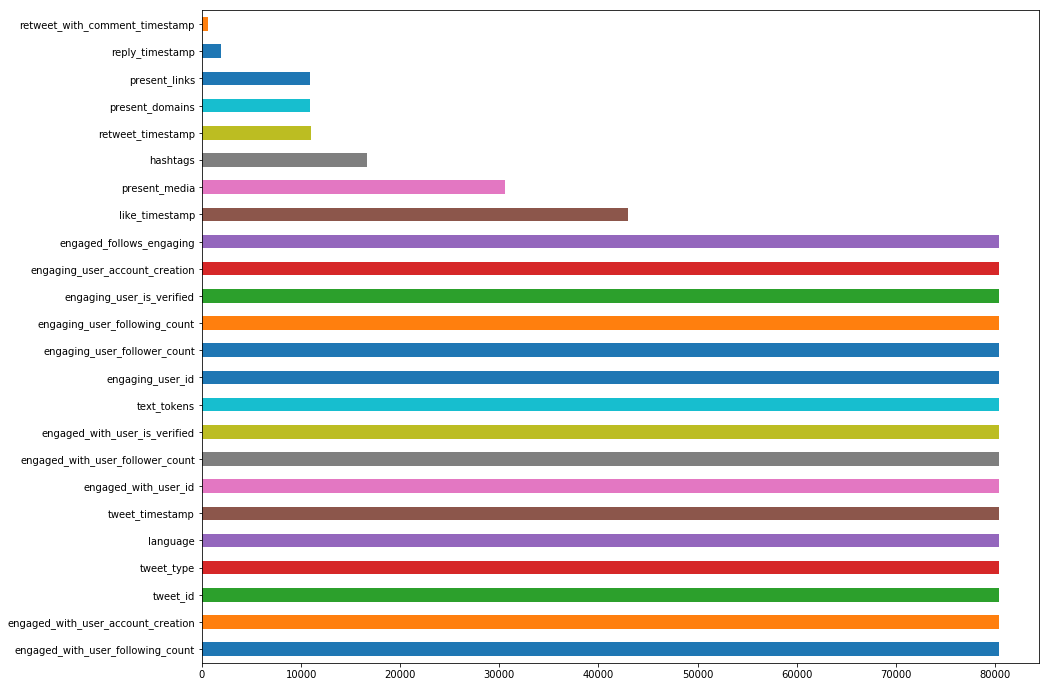

In [4]:
p_count = df.count() # to see missing values

fig, ax = plt.subplots(figsize=(15,12))
p_count.sort_values(ascending=False).plot.barh()

We can see that for half of the engagements there is no engagement timestamp at all. Exploration of the tweet type labels and the timestamp engagement variables might give further insights. 

## Explore data 


**Task: Explore data**\
This task tackles the data mining questions, which can be addressed
using querying, visualization and reporting. These include: 
* **distribution of key attributes**, for example the target attribute of a prediction task
* **relations** between pairs or small numbers of attributes
* results of **simple aggregations**
* properties of **significant sub-populations**
* **simple statistical analyses**. These analyses may address directly the data mining goals. they may also contribute to or refine the data description, quality reports, feed into the transformation and other data preparation needed for further analysis.


**Output: Data exploration report**\
Describe results of this task including 
* **first findings** or **initial hypothesis** and their **impact** on the remainder of the project. 
* If appropriate, include **graphs and plots**, which indicate data characteristics or lead to interesting **data subsets** for further examination.

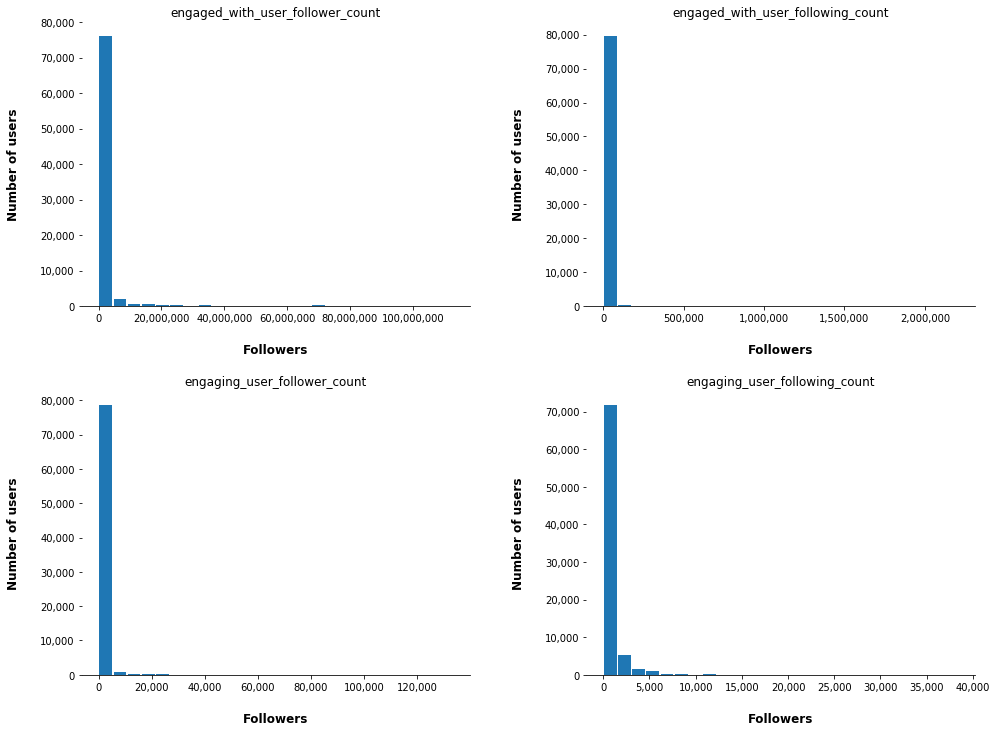

In [5]:
df_numeric = df[['engaging_user_follower_count',
                 'engaging_user_following_count',
                 'engaged_with_user_follower_count',
                 'engaged_with_user_following_count']]

fig, axes = plt.subplots(2, 2, figsize=(16,12))

df_numeric.hist(bins=25, 
                grid=False, 
                zorder=2, 
                rwidth=0.9,
                ax=axes)

for x in axes.reshape(-1): 
    #x.set_ylabel('test')
    
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Set x-axis label
    x.set_xlabel("Followers", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number of users", labelpad=20, weight='bold', size=12)
    
    # Format tick labels
    x.ticklabel_format(style='plain')
    x.get_xaxis().set_major_formatter(tck.FuncFormatter(lambda x, p: format(int(x), ',')))
    x.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda x, p: format(int(x), ',')))


A powerlaw distribution can be observed. Needs to be transformed using a powertransformation to have a gaussian-like distribution in a later step.

As a next step we want to explore the missingness of the timestamp engagement variables as seen in the data description section. We will further explore for which tweet types they are missing.

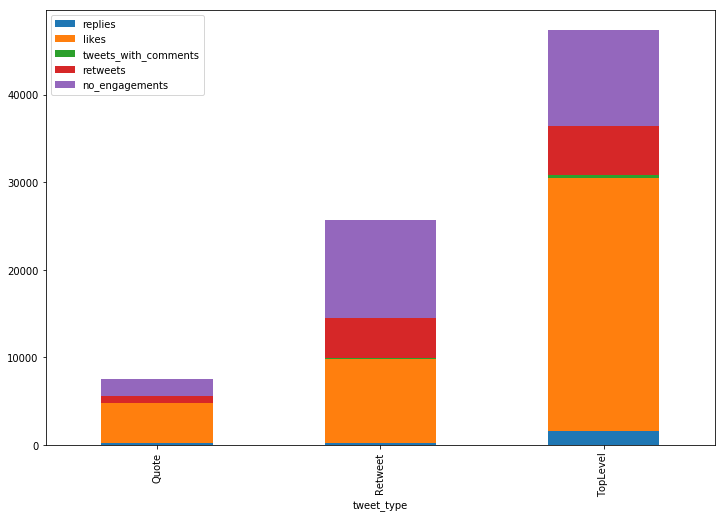

In [6]:
#'engaging_user_id', 'tweet_id'
# tweet_types according to description: Retweet, Quote, Reply, or Toplevel
df_subset = df[['tweet_type',
                 'tweet_id',
                 'reply_timestamp', 
                 'like_timestamp',
                 'retweet_with_comment_timestamp', 
                 'retweet_timestamp']]

df_explore = df_subset.groupby('tweet_type', as_index=False).agg({'reply_timestamp': 'count',
                                                                  'like_timestamp': 'count',
                                                                  'retweet_with_comment_timestamp': 'count', 
                                                                  'retweet_timestamp': 'count', 
                                                                  'tweet_id': 'count'})
# Rename columns
df_explore.columns = ['tweet_type',
                      'replies', 
                      'likes',
                      'tweets_with_comments', 
                      'retweets', 
                      'count_tweets']
                                                                  
df_explore['no_engagements'] = df_explore['count_tweets'] - df_explore[['replies',
                                           'likes',
                                           'tweets_with_comments', 
                                           'retweets',]].sum(axis=1)              
                                                                  
                                                                  
                                                                  
df_explore_plot = df_explore[['tweet_type',
                      'replies', 
                      'likes',
                      'tweets_with_comments', 
                      'retweets', 
                      'no_engagements']]

df_explore_plot.set_index('tweet_type', inplace=True)

fig, axes = plt.subplots(1,1,figsize=(12,8))
df_explore_plot.plot(kind='bar', 
                stacked=True, 
                ax=axes)
plt.show()

There are roughly 50% "no engagements" for retweets as we can see from the plot. This means that on average every user is interacting with 50% of all tweets in the world. Does the sample data set represent the real world?

/Users/timi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log10



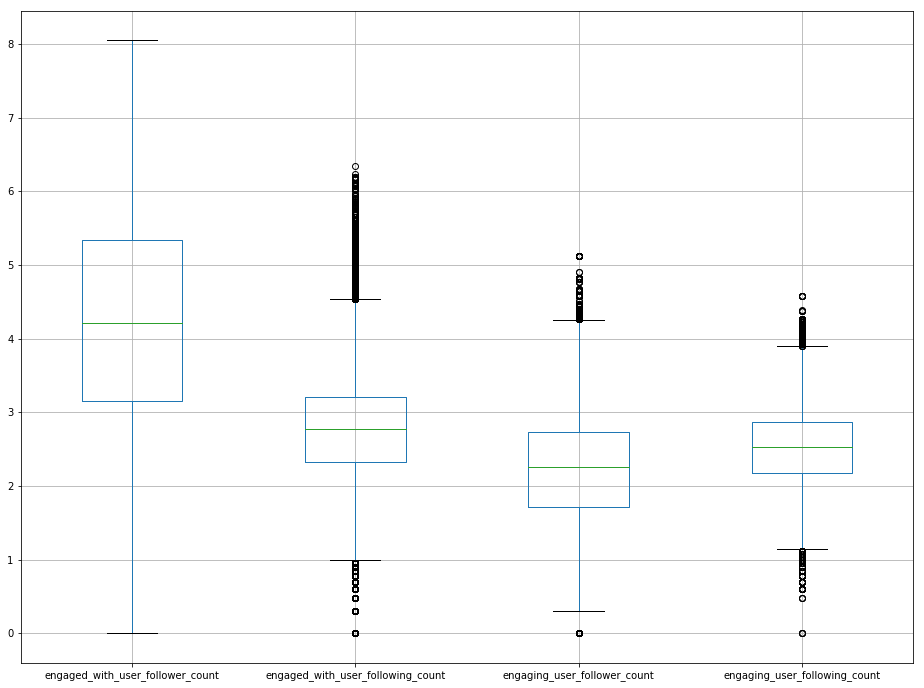

In [7]:
# TODO(optional): qq-plot for numeric variables. Boxplots already show distribution, that's why this is only optional

# boxplot of numeric variables
df_numbers = df[['engaged_with_user_follower_count',
    'engaged_with_user_following_count',
    'engaging_user_follower_count',
    'engaging_user_following_count']]
df_numbers = np.log10(df_numbers)
fig, axes = plt.subplots(1, 1, figsize=(16,12))
df_numbers.boxplot()

#fig, axes = plt.subplots(1, 1, figsize=(16,12))
#df.boxplot()

## Verify data quality

**Task: Verify data quality**\
Examine the quality of the data, addressing questions such as: 
* is the data **complete** (does it cover all the cases required)? 
* Is it correct or does it contain **errors** and if there are errors **how common** are they?
* Are there **missing values** in the data? If so how are they represented, where do they occur and how common are they?


**Output: Data quality report**\
List the results of the data quality verification; if quality problems
exist, list possible solutions. Solutions to data quality problems
generally depend heavily on both data and business knowledge.

In [8]:
display(df)

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
0,101\t56898\t137\t174\t63247\t10526\t131\t3197\...,NaN,3C21DCFB8E3FEC1CB3D2BFB413A78220,Video,NaN,NaN,Retweet,76B8A9C3013AE6414A3E6012413CDC3B,1581467323,D1AA2C85FA644D64346EDD88470525F2,737,706,False,1403069820,000046C8606F1C3F5A7296222C88084B,131,2105,False,1573978269,False,NaN,NaN,NaN,NaN
1,101\t102463\t10230\t10105\t21040\t10169\t12811...,NaN,3D87CC3655C276F1771752081423B405,NaN,BB422AA00380E45F312FD2CAA75F4960,92D397F8E0F1E77B36B8C612C2C51E23,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580975391,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,1230139136,00006047187D0D18598EF12A650E1DAC,22,50,False,1340673962,False,NaN,NaN,NaN,NaN
2,101\t56898\t137\t11255\t22037\t10263\t168\t111...,DB32BD91C2F1B37BE700F374A07FBC61,3701848B96AA740528A2B0E247777D7D,NaN,2423BA02A75DB2189335DDC3FB6B74A1,6D323BE93766E79BE423FAC5C28BE39B,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581257232,5C671539CB41B9807E209349B101E9FF,988,167,False,1530094483,0000648BAA193AE4C625DDF789B57172,251,719,False,1456473671,False,NaN,NaN,NaN,NaN
3,101\t13073\t28757\t106\t100\t14120\t131\t120\t...,NaN,18176C6AD2871729384062F073CCE94D,Video,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581164292,70B900BE17416923D1E236A38798F202,1228134,5413,False,1378699943,000071667F50BAFEA722A8E8284581E5,18,58,False,1378427564,False,NaN,NaN,NaN,1.581305e+09
4,101\t3460\t1923\t6632\t2824\t30368\t2179\t1881...,NaN,AF11AF01F842E7F120667B7B0B38676D,NaN,NaN,NaN,Quote,22C448FF81263D4BAF2A176145EE9EAD,1581233650,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,1549054499,00007745A6EE969F1A0F44B10DC17671,268,526,False,1252294800,False,NaN,NaN,NaN,NaN
5,101\t46242\t40751\t161\t100062\t10107\t10114\t...,NaN,4EC1C41302B820B2459337FE31859B16,NaN,BB79CD318A68247B64F0E0BE7AFD5A92,3896E26D12C903F0A00B6B1BE9A9BEA3,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581426841,959F94011E65010724E85D1B5CBAE18F,45488,6709,True,1415444172,00008C78BF1DDCC9FDCBAFFAF318A175,34,36,False,1538872824,False,NaN,NaN,NaN,NaN
6,101\t56898\t137\t10192\t11373\t10500\t131\t219...,NaN,5A943B66B4A519817AFCD1A72F9D42BF,NaN,NaN,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581289560,0062177976C63B01A6ED88EA32B16EE3,3205,1209,False,1480887745,000094A5EE8ADAC663B322D9D7E8D4F5,67,87,False,1540388888,True,NaN,NaN,NaN,NaN
7,101\t65724\t15619\t22859\t14120\t131\t120\t120...,NaN,E4EC2A529D2B45613E1BD71E7E8A33F0,Video,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581547705,3D051D82250859217FBA448B93E1957D,16385,640,True,1165379179,0000A7ECE87C3E55F4C0ECB86805DBCF,1273,271,False,1215849548,False,NaN,NaN,NaN,1.581548e+09
8,101\t100\t45031\t43804\t10121\t10146\t89387\t1...,NaN,43C1C8729853BF2C2CF58D0CFFE6F284,Photo,EF5D0A312E7A9BAEFBEA72A062E5F6CE,3183ACF54B4022B25B4157B81C174DD5,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581031483,033DB4138030ED8CF94BF33DEBB0CB39,3126043,105891,True,1235854449,0000FF30C15DDAFB6BB0FE2EE275CD6B,38,87,False,1540785155,False,NaN,NaN,NaN,NaN
9,101\t56898\t137\t26037\t91678\t168\t15734\t737...,NaN,D1FDD2ED8C6C80C2680E9746E70F5CFE,NaN,NaN,NaN,Retweet,06D61DCBBE938971E1EA0C38BD9B5446,1581545364,D8F0311F254EF83F42719567A94B93DA,515,498,False,1555968118,0001075D4E0F573E579B79ADDFD54712,96,105,False,1283277064,True,NaN,NaN,NaN,1.581548e+09


In [9]:
# check for duplicate rows, there are none
df_duplicated = df[df.duplicated()]
display(df_duplicated)

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp


**Completeness**\
The dataset provided by twitter is sparse but the sparseness is justified and NaN values are not considered as missing due to technical errors but due to the nature of social networks where hashtags, media and links are not always part of a message (tweet).

**Possible errors**\
Why do some users have the exactly same timestamp for two types of engagements (e.g. row_id 80424)?

**Missing values** (only unjustified ones):
* more than 21.000 records have no timestamp values in any of the engagement variables. 

# Data Preparation

## Select data

**Task: Select data**\
Decide on the data to be used for analysis. Criteria include relevance
to the data mining goals, quality and technical constraints such as
limits on data volume or data types. Note that data selection covers
selection of attributes (columns) as well as selection of records (rows)
in a table.

**Output: Rationale for inclusion/exclusion**\
List the data to be included/excluded and the reasons for these decisions.

The (pre-)selection process was made outside of this notebook. The original dataset from Twitter contained 160M tweets, recorded within a two week period. As this set contained to many "non-relevant" records with no engagements a subset was created where the proportion of no-enagement records was lowered. As seen in the data quality section above, the current subsample might not represent the real world but it suffices for our purpose of training a baseline and an alternative model.

## Clean data

**Task: Clean data**\
Raise the data quality to the level required by the selected analysis
techniques. This may involve selection of clean subsets of the data, the
insertion of suitable defaults or more ambitious techniques such as the
estimation of missing data by modeling.


**Output: Data cleaning report**\
Describe what decisions and actions were taken to address the data
quality problems reported during the verify data quality task of the
data understanding phase. Transformations of the data for cleaning
purposes and the possible impact on the analysis results should be
considered.

As the provided subsampled dataset is already preprocessed by means of row selection and cleaning and we did not encounter any "dirty rows" we leave the dataset as it is and continue with enhancing it with new columns in the next section.

## Construct data

**Task: Construct data**\
This task includes constructive data preparation operations such as the
production of derived attributes, entire new records or transformed
values for existing attributes.


**Outputs: Derived attributes**\
Derived attributes are new attributes that are constructed from one or more
existing attributes in the same record. Examples: area = length * width.
Generated records
Describe the creation of completely new records. Example: create
records for customers who made no purchase during the past year.
There was no reason to have such records in the raw data, but for
modeling purposes it might make sense to explicitly represent the fact
that certain customers made zero purchases.

### Enhance dataset with derived columns

We used the aggregation method count on several non-numerical variables to produce further independent variables on tweet level that might help us in predicting engagements. Also we encoded the engagement variables to a boolean type. \
The table below shows all the variables that the dataset will contain at the end of this section.

| Aggregation level | Name | Type | Description |
| --- | --- | --- | --- |
| tweet | has_media | bool | Indicates that is there any media type related to the tweet or not? (should be omitted later, it was just a helper for further extraction) |
| tweet | cnt_Photo | Integer | number of photo media in the tweet |
| tweet | cnt_Video | Integer | number of video media in the tweet|
| tweet | cnt_GIF | Integer | number of GIF media in the tweet |
| tweet | cnt_Other_media | Integer | (maybe it's impossible) if there is an unknown media type, it will be counted |
| tweet | cnt_Hashtags | Integer | Count the number of hashtags in each tweet |
| tweet | cnt_Domains | Integer | Count the number of domains in each tweet |
| tweet | cnt_Links | Integer | Count the number of links in each tweet |
| tweet | cnt_Words_In_Tweet | Integer | Count the number of words in the tweet |
| tweet | is_like | bool | indicates that was there a like by the engaging user on the tweet (decided on that is there timestamp exists or not) |
| tweet | is_reply | bool | indicates that was there a reply by the engaging user on the tweet (decided on that is there timestamp exists or not) |
| tweet | is_retweet | bool | indicates that was there a retweet by the engaging user on the tweet (decided on that is there timestamp exists or not) |
| tweet | is_retweet_with_comment | bool | indicates that was there a retweet with comment by the engaging user on the tweet (decided on that is there timestamp exists or not) |
| tweet | daytime | Categorical |timestamp of tweet encoded as 'morning', 'afternoon', 'evening' and 'night'|
| tweet | text_tokens_tfidf | sparse matrix |TFIDF scores of the stopword-filtered tweet tokens  |
| user | cnt_likes | Integer | Number of likes a user gave |
| user | cnt_replies | Integer | Number of replies a user gave |
| user | cnt_retweets | Integer | number of retweets a user sent |
| user | cnt_retweets_with_comment | Integer | number of retweets with comment a user sent |
| user | cnt_tweets | Integer | number of tweets a user sent |

First we enhance the dataset with **aggregations on tweet level**. 

In [10]:
# helper variable
df['has_media'] = df['present_media'].notna()

# Count the different media types for every tweet
photoCnt = []
videoCnt = []
gifCnt = []
other = []

for d,b in zip(df['present_media'],  df['has_media']):
    if b is True:
        pht = d.count("Photo")
        video = d.count("Video")
        gif  = d.count("GIF")
        
        photoCnt.append(pht)
        videoCnt.append(video)
        gifCnt.append(gif)

        if len(str(d).split()) != int(pht + video + gif):
             other.append(len(str(d).split()) - int(pht + video + gif))
        else:
             other.append(0)
    else:
        photoCnt.append(0)
        videoCnt.append(0)
        gifCnt.append(0)
        other.append(0)
        
df['cnt_Photo'] = photoCnt
df['cnt_Video'] = videoCnt
df['cnt_GIF'] = gifCnt
df['cnt_Other_Media'] = other


# Count the number of hashtags, links, domains and words in each tweet
df['cnt_Hashtags'] = df.apply(lambda x : len(str(x['hashtags']).split()) if str(x['hashtags']) != "nan" else 0,axis=1)
df['cnt_Links'] = df.apply(lambda x : len(str(x['present_links']).split()) if str(x['present_links']) != "nan" else 0,axis=1)
df['cnt_Domains'] = df.apply(lambda x : len(str(x['present_domains']).split()) if str(x['present_domains']) != "nan" else 0,axis=1)
df['cnt_Words_In_Tweet'] = df.apply(lambda x : len(str(x['text_tokens']).split()) if str(x['text_tokens']) != "nan" else 0,axis=1)

# Converting tweet timestamp into categorical (morning, afternoon, evening, night) variable
from datetime import datetime, timezone
def get_part_of_day(timestamp):
    t=datetime.fromtimestamp(timestamp)
    hour=int(t.strftime('%H'))
    return (
        "morning" if 5 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night"
)
df['daytime'] = df.apply(lambda x: get_part_of_day(x['tweet_timestamp']), axis=1)

Now, as we derived some new attributes we also want to explore them. We are interested in the proportion of words, hashtags, links and domains in tweets


In [11]:
# dfCountToPlot = df[['cnt_Words_In_Tweet', 'cnt_Hashtags',  'cnt_Links', 'cnt_Domains']]
# plt.plot(dfCountToPlot)
# plt.ylabel('Words in tweets') # previously called: some numbers
# plt.show()

# Takes very long to compute! maybe histogram would be better


We encode the **engagement types as binary integer values** as we are not going to predict timestamps but probabilities of engagements. That's why we also rename the engagement variables so that the names fit their binary representation.

In [12]:
df['reply_timestamp'] = df['reply_timestamp'].notna().astype(int)
df['like_timestamp'] = df['like_timestamp'].notna().astype(int)
df['retweet_with_comment_timestamp'] = df['retweet_with_comment_timestamp'].notna().astype(int)
df['retweet_timestamp'] = df['retweet_timestamp'].notna().astype(int)

df.rename(columns={'reply_timestamp':'is_reply',
                   'like_timestamp':'is_like',
                   'retweet_with_comment_timestamp':'is_retweet_with_comment',
                   'retweet_timestamp':'is_retweet'},
          inplace=True)
 

In the following cell we create some **user level aggregations**, namely, counts for each dependent variable and tweet counts. 

In [13]:
# Counts on user level

# engagement types counts
df_user_variables_counts = df[['engaging_user_id',
                               'is_reply', 
                               'is_like',
                               'is_retweet_with_comment', 
                               'is_retweet']].groupby(['engaging_user_id'], as_index=False).sum()
df_user_variables_counts.columns = ['engaging_user_id', 
                                    'cnt_engaging_user_replies',
                                    'cnt_engaging_user_likes',
                                    'cnt_engaging_user_retweets_with_comments',
                                    'cnt_engaging_user_retweets']
# tweet counts
df_user_tweet_counts = df[['tweet_id', 
                           'engaging_user_id']].groupby(['engaging_user_id'],
                                                        as_index=False).count().sort_values(by='tweet_id',
                                                                                            ascending=False)
df_user_tweet_counts.columns = ['engaging_user_id', 
                                    'cnt_user_tweets']

# Merge both derived dataframes to main data frame
df = df.merge(df_user_variables_counts, 
         how='left', 
         left_on='engaging_user_id', 
         right_on='engaging_user_id')


df = df.merge(df_user_tweet_counts, 
         how='left', 
         left_on='engaging_user_id', 
         right_on='engaging_user_id')

#df.join(df_user_variables_counts, on='engaging_user_id', how='left')

#### T4. Extract the Social Network
* Twitter Social Network is directional (follower – following) 
* parse the `engaged_follows_engaging` field: each example gives you an edge
* Create the adjacency matrix representation of the social graph
* If an edge exists between two users, 0 otherwise
* how can you use this information?

In [14]:
unique_user_ids = df['engaging_user_id'].append(df['engaged_with_user_id']).unique()

m = len(unique_user_ids)

userId_to_userIDX = dict(zip(unique_user_ids, range(m)))
userIDX_to_userId = dict(zip(range(m), unique_user_ids))

e_df = df[df['engaged_follows_engaging']][['engaging_user_id', 'engaged_with_user_id', 'engaged_follows_engaging']]

e_df['engaging_user_idx'] = e_df['engaging_user_id'].map(userId_to_userIDX)
e_df['engaged_with_user_idx'] = e_df['engaged_with_user_id'].map(userId_to_userIDX)

e_df.sort_values(by=['engaging_user_idx'], inplace = True)
e_df.drop_duplicates(inplace = True)
e_df.reset_index(drop = True, inplace = True)

# Creating the social network matrix
SN = sp.csr_matrix((e_df.engaged_follows_engaging, (e_df.engaging_user_idx, e_df.engaged_with_user_idx)), shape=(m, m))
SN.shape

(65963, 65963)

Using the adjacency matrix, we can create a graph that represents the connection (following) between the users. Remember: the "engaged_follows_engaging" attribute represents whether the user who created the engaded tweet follows the user who is engaging. Then we can have a graph with 65963 nodes and 24234 edges.

In [15]:
G = nx.from_scipy_sparse_matrix(SN,parallel_edges=True,create_using=nx.DiGraph())
G=G.reverse()
print("{} nodes, {} edges".format(len(G), nx.number_of_edges(G)))

65963 nodes, 24235 edges


Let us now calculate the centralities

In [16]:
in_degree = dict(G.in_degree())
c_df=pd.DataFrame(sorted(in_degree.items(), key=lambda x: x[1], reverse=True),columns=['id', 'in_degree'])

# map back ids to user ids from the original dataframe
c_df['id']=c_df['id'].map(userIDX_to_userId)

# create a dictionary of user ids and centrality measures to speed-up mapping with the original df
c_dict=c_df.set_index('id').T.to_dict('list')
df['engaging_user_centrality']=df['engaging_user_id'].map(c_dict).apply(lambda x: x[0])

Encoding centrality measures to True or False bool variable (True means the engaging user is important in the network, having degree centrality value greater than the median).

In [17]:
display(df['engaging_user_centrality'].median())
df['is_engaging_user_centrality']=df['engaging_user_centrality']>df['engaging_user_centrality'].median()
df.head()

2.0

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,is_reply,is_retweet,is_retweet_with_comment,is_like,has_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media,cnt_Hashtags,cnt_Links,cnt_Domains,cnt_Words_In_Tweet,daytime,cnt_engaging_user_replies,cnt_engaging_user_likes,cnt_engaging_user_retweets_with_comments,cnt_engaging_user_retweets,cnt_user_tweets,engaging_user_centrality,is_engaging_user_centrality
0,101\t56898\t137\t174\t63247\t10526\t131\t3197\...,NaN,3C21DCFB8E3FEC1CB3D2BFB413A78220,Video,NaN,NaN,Retweet,76B8A9C3013AE6414A3E6012413CDC3B,1581467323,D1AA2C85FA644D64346EDD88470525F2,737,706,False,1403069820,000046C8606F1C3F5A7296222C88084B,131,2105,False,1573978269,False,0,0,0,0,True,0,1,0,0,0,0,0,31,night,0,0,0,0,4,0,False
1,101\t102463\t10230\t10105\t21040\t10169\t12811...,NaN,3D87CC3655C276F1771752081423B405,NaN,BB422AA00380E45F312FD2CAA75F4960,92D397F8E0F1E77B36B8C612C2C51E23,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580975391,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,1230139136,00006047187D0D18598EF12A650E1DAC,22,50,False,1340673962,False,0,0,0,0,False,0,0,0,0,0,1,1,34,morning,0,1,0,0,6,1,False
2,101\t56898\t137\t11255\t22037\t10263\t168\t111...,DB32BD91C2F1B37BE700F374A07FBC61,3701848B96AA740528A2B0E247777D7D,NaN,2423BA02A75DB2189335DDC3FB6B74A1,6D323BE93766E79BE423FAC5C28BE39B,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581257232,5C671539CB41B9807E209349B101E9FF,988,167,False,1530094483,0000648BAA193AE4C625DDF789B57172,251,719,False,1456473671,False,0,0,0,0,False,0,0,0,0,1,1,1,89,afternoon,1,2,0,0,4,1,False
3,101\t13073\t28757\t106\t100\t14120\t131\t120\t...,NaN,18176C6AD2871729384062F073CCE94D,Video,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581164292,70B900BE17416923D1E236A38798F202,1228134,5413,False,1378699943,000071667F50BAFEA722A8E8284581E5,18,58,False,1378427564,False,0,0,0,1,True,0,1,0,0,0,0,0,22,afternoon,0,1,0,0,7,0,False
4,101\t3460\t1923\t6632\t2824\t30368\t2179\t1881...,NaN,AF11AF01F842E7F120667B7B0B38676D,NaN,NaN,NaN,Quote,22C448FF81263D4BAF2A176145EE9EAD,1581233650,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,1549054499,00007745A6EE969F1A0F44B10DC17671,268,526,False,1252294800,False,0,0,0,0,False,0,0,0,0,0,0,0,31,morning,0,2,0,0,5,3,True


#### TF-IDF
First we need to format our *text_tokens* attribute and split the tab-separated values into a list. 

In [18]:
def to_hex_list(x):
    output = str(x).split('\t')
    return output

df['text_tokens'] = df['text_tokens'].apply(lambda x: to_hex_list(x) if isinstance(x, str)  else x)

Now we define stopwords to remove them from the *text_tokens* attribute and create a new *text_tokens_tfidf* attribute which holds the filtered words.

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
engStopwords = text.ENGLISH_STOP_WORDS.union(["book"])


# Create a BERT-encoded stopword list. 
# Also the BERT placeholders such as CLS and SEP  will be considered as stopword

#Initalize the list as set to avoid duplicates
tokensToFilter = set()

# Add BERT separators to filter list
tokensToFilter.add(100)
tokensToFilter.add(101)
tokensToFilter.add(102)

#Add english tokens
for s in engStopwords:
    idS =   tokenizer.encode(s)
    for i in idS:
        tokensToFilter.add(i)
        
#Remove the stop words
textTokensFiltered = []
for t in df['text_tokens']:
    newTokens = []
    for token in t:
        if int(token) not in tokensToFilter:
            newTokens.append(token)
    
    textTokensFiltered.append(" ".join(newTokens))
    
#df['text_tokens_filtered'] = textTokensFiltered
#df["text_tokens_tfidf"] = TfidfVectorizer().fit_transform(textTokensFiltered)
tfIDF = TfidfVectorizer(max_features = 4000)

tfIDFVocab = tfIDF.fit(textTokensFiltered)
tfIDFScores = tfIDFVocab.transform(textTokensFiltered)

Create a tf-idf score pandas dataframe: the top 4000 features will be the columns: in each row, the filtered tokens will be checked against the column names in the tf idf score dataframe: if the actual feature name exists in the column names, the appropraite score (selected by the actual index) will be added to the list of scores (for each row, list will be initialized))

In [20]:
tfIDFPandas =  pd.DataFrame(tfIDFScores.toarray(), columns=tfIDFVocab.get_feature_names())

In [21]:
#Initialize a list
tfIdfScoreCol = []
#Store the name of the columns in a variable
topFeatures = tfIDFPandas.columns
#Loop through the dataframe
for index, row in tfIDFPandas.iterrows():
    #Initialize a list of the current row: this will store the appropriate tf-idf scores
    scoresInRow = []
    #Split the tokens based on whitespace
    for t in textTokensFiltered[index].split(' ') :
        #In some cases some empty chars remain, they must be skipped
        # if the token also exist in the tf idf dataframe as column name, the appropriate score will be added to the list
        if(all([t != "" , t in topFeatures])):
            score = float(row.loc[(t)])
            scoresInRow.append(score)
    
    #After the appropriate token-related relevance scores added to the list, append the list to the outer list
    tfIdfScoreCol.append(scoresInRow)        

In [22]:
df['text_tokens_tfidf'] = tfIdfScoreCol

### Exploring newly derived columns

Let us look at some distribution of the new variables. It is not surprising that we again encounter a skewed normal distribution

Text(0,0.5,'number of users')

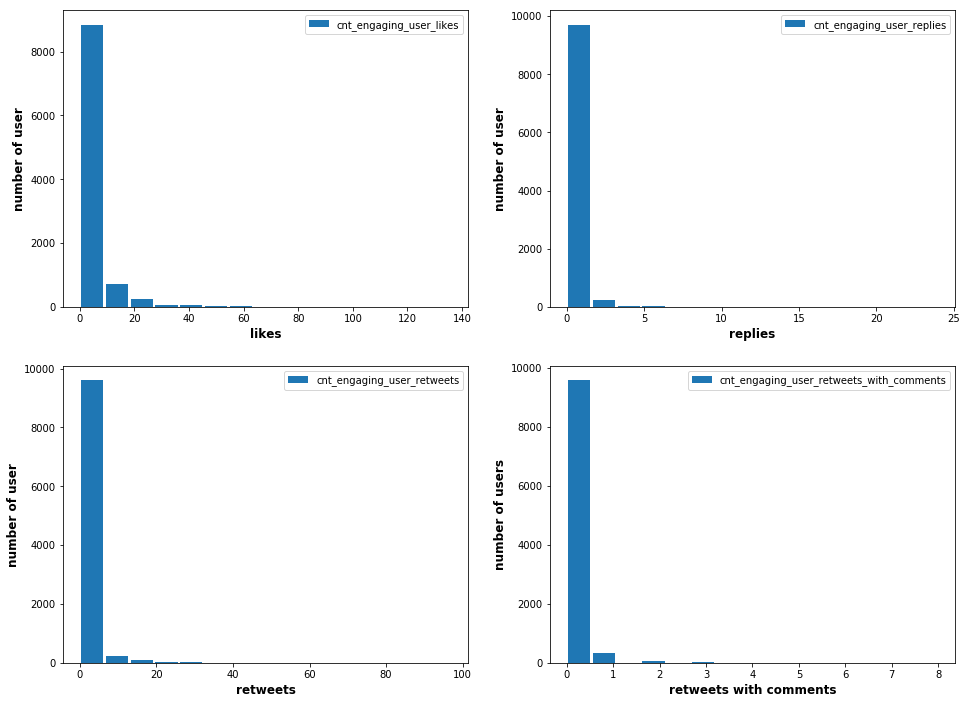

In [23]:
fig, axes = plt.subplots(2,2,figsize=(16,12))


df_user_variables_counts[['engaging_user_id', 'cnt_engaging_user_likes']].plot(kind='hist', 
                                                                               bins=15, 
                                                                               ax=axes[0,0],
                                                                               zorder=2,
                                                                               rwidth=0.9)
axes[0,0].set_xlabel("likes", weight='bold', size=12)
axes[0,0].set_ylabel("number of user", weight='bold', size=12)

df_user_variables_counts[['engaging_user_id', 'cnt_engaging_user_replies']].plot(kind='hist', 
                                                                               bins=15, 
                                                                               ax=axes[0,1],
                                                                               zorder=2,
                                                                               rwidth=0.9)
axes[0,1].set_xlabel("replies", weight='bold', size=12)
axes[0,1].set_ylabel("number of user", weight='bold', size=12)

df_user_variables_counts[['engaging_user_id', 'cnt_engaging_user_retweets']].plot(kind='hist', 
                                                                               bins=15, 
                                                                               ax=axes[1,0],
                                                                               zorder=2,
                                                                               rwidth=0.9)
axes[1,0].set_xlabel("retweets", weight='bold', size=12)
axes[1,0].set_ylabel("number of user", weight='bold', size=12)

df_user_variables_counts[['engaging_user_id', 'cnt_engaging_user_retweets_with_comments']].plot(kind='hist', 
                                                                               bins=15, 
                                                                               ax=axes[1,1],
                                                                               zorder=2,
                                                                               rwidth=0.9)
axes[1,1].set_xlabel("retweets with comments", weight='bold', size=12)
axes[1,1].set_ylabel("number of users", weight='bold', size=12)


Visualizing the distribution of tweet times

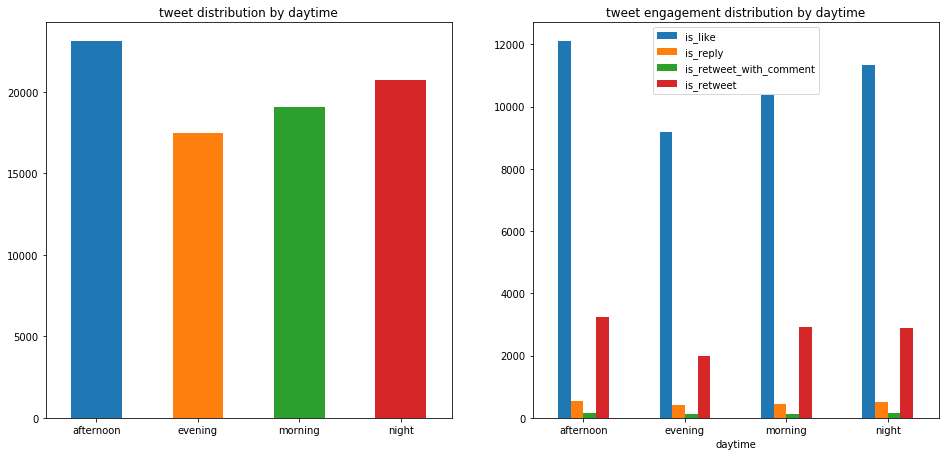

In [24]:
plt.figure(figsize=(16, 16))

ax1 = plt.subplot(221)
df['daytime'].value_counts().sort_index().plot(kind='bar',
                                               rot=0,
                                               ax=ax1,
                                               title='tweet distribution by daytime')
ax2 = plt.subplot(222)
df.groupby('daytime')[['is_like',
                      'is_reply',
                      'is_retweet_with_comment',
                      'is_retweet']].sum().sort_index().plot.bar(rot=0,
                                                                ax=ax2,
                                                                title='tweet engagement distribution by daytime')
plt.show()

In the social network section we created a new boolen variable (is_engaging_user_centrality), that is true if the engaging user has a centrality value greater than the median of all centrality values. Here we display the distribution of the users based on this variable. We can see that there are more users where is_engaging_user_centrality is false. After that we checked the number of engagedements (like, reply etc) grouped by the is_engaging_user_centrality variable and we can see, that there are more engagedements among the engaging users where is_engaging_user_centrality is true so user centrality is greater than the median centrality. From this we can conclude that the user centrality within the network has an impact on the probability of engagement, because we got higher numbers for the engagement types among the users whose centrality value is greater. 

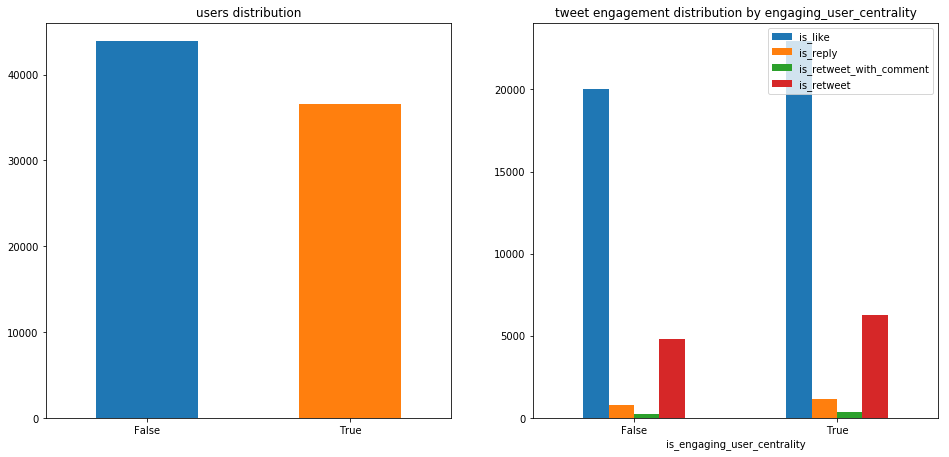

In [25]:
plt.figure(figsize=(16, 16),)

ax1 = plt.subplot(221)
df['is_engaging_user_centrality'].value_counts().sort_index().plot(kind='bar',
                                                                   rot=0,ax=ax1,
                                                                   title='users distribution')

ax2 = plt.subplot(222)
df.groupby('is_engaging_user_centrality')[['is_like',
                                           'is_reply',
                                           'is_retweet_with_comment',
                                           'is_retweet']].sum().sort_index().plot.bar(rot=0,
                                                                                      ax=ax2,
                                                                                      title='tweet engagement distribution by engaging_user_centrality')

plt.show()

In [26]:
# TODO (filip): insert td-idf from pre-process notebook

## Format data

**Task: Format data**\
Formatting transformations refer to primarily syntactic modifications
made to the data that do not change its meaning, but might be required
by the modeling tool.


**Output: Reformatted data**\
Some tools have requirements on the order of the attributes, such as
the first field being a unique identifier for each record or the last field
being the outcome field the model is to predict.
It might be important to change the order of the records in the dataset.
Perhaps the modeling tool requires that the records be sorted according
to the value of the outcome attribute. A common situation is that the
records of the dataset are initially ordered in some way but the modeling
algorithm needs them to be in a fairly random order. For example, when
using neural networks it is generally best for the records to be presented
in a random order although some tools handle this automatically without explicit user intervention

First, we define some variable sets that will be formated and encoded later on

In [27]:
# Now let us split the variable sets based on their categories
timestamp_cols = ['tweet_timestamp', 'engaging_user_account_creation', 'engaged_with_user_account_creation']

response_cols = ['is_reply', 
                 'is_retweet',
                 'is_retweet_with_comment', 
                 'is_like']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = df.select_dtypes(include=numerics).columns.tolist()
numeric_cols = list(set(numeric_cols) - set(timestamp_cols) - set(response_cols))

categorical_cols = ['tweet_type', 'language', 'daytime', 
                    'engaged_with_user_is_verified', 'engaging_user_is_verified', 
                    'engaged_follows_engaging', 'is_engaging_user_centrality']

id_cols = ['tweet_id', 'engaged_with_user_id', 'engaging_user_id']

# TODO: include text_tokens_tdidf. Currently there is an issue when encoding tweet_feature_cols in the Modelling section
tweet_feature_cols = ['text_tokens', 'hashtags', 'present_media', 'present_links', 'present_domains', 'text_tokens_tfidf']
#tweet_feature_cols = ['text_tokens', 'hashtags', 'present_media', 'present_links', 'present_domains']


In [28]:
def fill_NaNs(x, replacement = ['Unknown']):
    series =  pd.Series([replacement if y is np.nan else y for y in x])
    return series

#currently not used
def convert_to_int(x):
    return x.notnull().astype('int') # does produce only 1s

def categorical_cat(x):
    return x.astype('category')

#currently not used
def id_cat(x, buckets = 1000):
    return x.apply(lambda y : abs(hash(y)) % buckets).astype('category')



# fill NaN values of tweet features with 'Unknown'
cols_to_process = tweet_feature_cols
df[cols_to_process] = df[cols_to_process].apply(fill_NaNs)

## Parse attributes containing tab-separated lists into lists.
cols_to_process = tweet_feature_cols
for col in cols_to_process:  
    df[col] = df[col].apply(lambda x: to_hex_list(x) if isinstance(x, str)  else x)

## Transform raw timestamps into human-readable timestamps.
cols_to_process = timestamp_cols

for col in cols_to_process:  
    df[col] = df[col].apply(lambda x: pd.Timestamp(x, unit='s'))


# Changes type of categorical variables to custom type 'category'
cols_to_process = categorical_cols
df[cols_to_process] = df[cols_to_process].apply(categorical_cat)

# Changes type of ID variables to custom type 'category'
#cols_to_process = id_cols
#df[cols_to_process] = df[cols_to_process].apply(id_cat)

# Results
print("\033[1m Tweet features that had NaN values before are now labeled as Unknown \033[0m \n", df[tweet_feature_cols].iloc[1])
print("\033[1m Features that were tab-separated before are now comma separated lists \033[0m \n", df[tweet_feature_cols].iloc[324])
print("\033[1m Features that had unreadable timestamps are human-readable now \033[0m \n", df[timestamp_cols].iloc[324])
#print("\033[1m Response variables are now binary \033[0m \n", df[response_cols].iloc[324])
print("\033[1m Categorical variables are now of custom type category. Example attribute: tweet_type \033[0m \n", df[['tweet_type']].iloc[324])
#print("\033[1m ID variables are now of custom type category. Example attribute: tweet_id \033[0m \n", df[['tweet_id']].iloc[324])

 Tweet features that had NaN values before are now labeled as Unknown  
 text_tokens          [101, 102463, 10230, 10105, 21040, 10169, 1281...
hashtags                                                     [Unknown]
present_media                                                [Unknown]
present_links                       [BB422AA00380E45F312FD2CAA75F4960]
present_domains                     [92D397F8E0F1E77B36B8C612C2C51E23]
text_tokens_tfidf    [0.2825400044052319, 0.08679267811654987, 0.29...
Name: 1, dtype: object
 Features that were tab-separated before are now comma separated lists  
 text_tokens          [101, 91327, 13028, 10142, 169, 14772, 28154, ...
hashtags                                                     [Unknown]
present_media                                                  [Photo]
present_links                                                [Unknown]
present_domains                                              [Unknown]
text_tokens_tfidf    [0.14526974151622857, 0.1569

In [29]:
df.head()

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engaged_follows_engaging,is_reply,is_retweet,is_retweet_with_comment,is_like,has_media,cnt_Photo,cnt_Video,cnt_GIF,cnt_Other_Media,cnt_Hashtags,cnt_Links,cnt_Domains,cnt_Words_In_Tweet,daytime,cnt_engaging_user_replies,cnt_engaging_user_likes,cnt_engaging_user_retweets_with_comments,cnt_engaging_user_retweets,cnt_user_tweets,engaging_user_centrality,is_engaging_user_centrality,text_tokens_tfidf
0,"[101, 56898, 137, 174, 63247, 10526, 131, 3197...",[Unknown],3C21DCFB8E3FEC1CB3D2BFB413A78220,[Video],[Unknown],[Unknown],Retweet,76B8A9C3013AE6414A3E6012413CDC3B,2020-02-12 00:28:43,D1AA2C85FA644D64346EDD88470525F2,737,706,False,2014-06-18 05:37:00,000046C8606F1C3F5A7296222C88084B,131,2105,False,2019-11-17 08:11:09,False,0,0,0,0,True,0,1,0,0,0,0,0,31,night,0,0,0,0,4,0,False,"[0.12630448139349, 0.1107427872583753, 0.31615..."
1,"[101, 102463, 10230, 10105, 21040, 10169, 1281...",[Unknown],3D87CC3655C276F1771752081423B405,[Unknown],[BB422AA00380E45F312FD2CAA75F4960],[92D397F8E0F1E77B36B8C612C2C51E23],TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,2020-02-06 07:49:51,4DC65AC7BD963DE1F7617C047C33DE99,52366425,2383,True,2008-12-24 17:18:56,00006047187D0D18598EF12A650E1DAC,22,50,False,2012-06-26 01:26:02,False,0,0,0,0,False,0,0,0,0,0,1,1,34,morning,0,1,0,0,6,1,False,"[0.2825400044052319, 0.08679267811654987, 0.29..."
2,"[101, 56898, 137, 11255, 22037, 10263, 168, 11...",[DB32BD91C2F1B37BE700F374A07FBC61],3701848B96AA740528A2B0E247777D7D,[Unknown],[2423BA02A75DB2189335DDC3FB6B74A1],[6D323BE93766E79BE423FAC5C28BE39B],Retweet,22C448FF81263D4BAF2A176145EE9EAD,2020-02-09 14:07:12,5C671539CB41B9807E209349B101E9FF,988,167,False,2018-06-27 10:14:43,0000648BAA193AE4C625DDF789B57172,251,719,False,2016-02-26 08:01:11,False,0,0,0,0,False,0,0,0,0,1,1,1,89,afternoon,1,2,0,0,4,1,False,"[0.04562204674412291, 0.040001055870187555, 0...."
3,"[101, 13073, 28757, 106, 100, 14120, 131, 120,...",[Unknown],18176C6AD2871729384062F073CCE94D,[Video],[Unknown],[Unknown],TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,2020-02-08 12:18:12,70B900BE17416923D1E236A38798F202,1228134,5413,False,2013-09-09 04:12:23,000071667F50BAFEA722A8E8284581E5,18,58,False,2013-09-06 00:32:44,False,0,0,0,1,True,0,1,0,0,0,0,0,22,afternoon,0,1,0,0,7,0,False,"[0.41994294906051993, 0.41994294906051993, 0.2..."
4,"[101, 3460, 1923, 6632, 2824, 30368, 2179, 188...",[Unknown],AF11AF01F842E7F120667B7B0B38676D,[Unknown],[Unknown],[Unknown],Quote,22C448FF81263D4BAF2A176145EE9EAD,2020-02-09 07:34:10,E94C0E9E8494F3D603F9D1A5C5242E3D,73,299,False,2019-02-01 20:54:59,00007745A6EE969F1A0F44B10DC17671,268,526,False,2009-09-07 03:40:00,False,0,0,0,0,False,0,0,0,0,0,0,0,31,morning,0,2,0,0,5,3,True,"[0.22081521963801906, 0.15991282086387965, 0.2..."


# 5. Modelling

## 5.1 Variable selection

Before we continue splitting the data into train and test sets we need to define our dependent and independent variables. We saw in the data exploration and furthermore in the data preparation section that many numerical attributes that are included in our dataset (original and enhanced) are skewed. That is why we first need to transform those variables and aim for a gaussian distribution as this is a requirement for our selected machine learning approaches.

In [30]:
# First, we exclude helper variables and variables that are certainly not going to be used
columns_to_exclude = ['has_media']

reduced_variable_set = list(set(df.columns.to_list()) - set(columns_to_exclude))
df = df[reduced_variable_set]

# We show the distribution of all numeric variables
df[numeric_cols].hist(bins=20, figsize=(25,20))
plt.show()

AttributeError: 'Index' object has no attribute 'to_list'

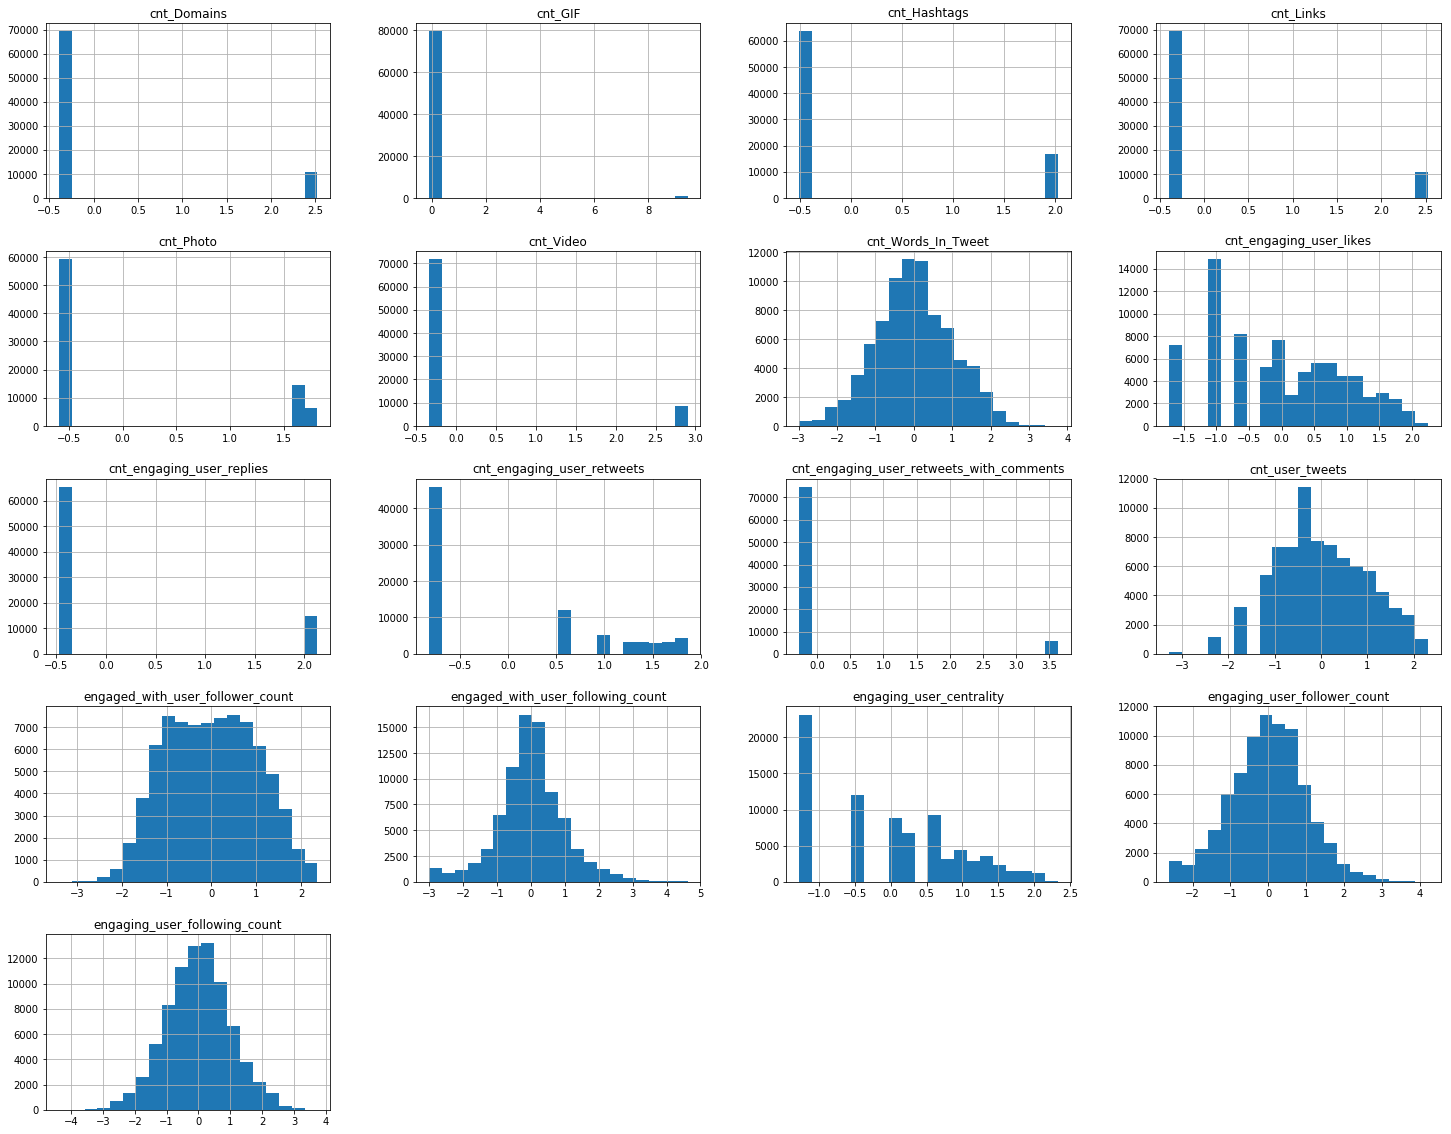

In [31]:
# We exclude further variables that would yield no information gain (have no variance)
columns_to_exclude = ['cnt_Other_Media']
df = df[df.columns.difference(columns_to_exclude)] # exclude from dataframe
numeric_cols = list(set(numeric_cols) - set(columns_to_exclude)) # exclude from numeric variables

# We scale the variables ...
scaler = PowerTransformer()
columns_to_transform = numeric_cols
scaler.fit(df[columns_to_transform])
df[columns_to_transform] = scaler.transform(df[columns_to_transform])

# ... and show the distributions again
df[columns_to_transform].hist(bins=20, figsize=(25,20))
plt.show()

After applying the powertransformer we can observe that some variables got transformed well into a gaussian-like distribution and others did not. We will again exclude those which did not yield any better results. Our variable selection of the numeric columns is purely based on visual aspects. Another more precise way would be to test whether the variables follow a gaussian distribution and decide based on a certain alpha level.

In [32]:
columns_to_exclude = ['cnt_Domains', 'cnt_GIF', 'cnt_Hashtags', 'cnt_Links', 'cnt_Photo', 
                     'cnt_Video', 'cnt_engaging_user_replies','cnt_engaging_user_retweets',
                      'cnt_engaging_user_retweets_with_comments']
df = df[df.columns.difference(columns_to_exclude)] # exclude from dataframe
numeric_cols = list(set(numeric_cols) - set(columns_to_exclude)) # exclude from numeric variables

## 5.2 Generate test design

The ground truth will be used in the model evaluation on the test data. It is the set of relevant items and the predicted values for the test set will be compared against it. It will be done separately for each dependent variable.

### T1. Split into train, dev, test
* Sub-sample to create test, non-test datasets
* Optionally split non-test into train and dev
* e.g., to implement k-fold validation

In [33]:
train, test = train_test_split(df, test_size = 0.1, random_state = 42)
train = train.reset_index()
test = test.reset_index()

print(train.shape, type(train), test.shape, type(test))
# TODO: optional: dev set

(72382, 33) <class 'pandas.core.frame.DataFrame'> (8043, 33) <class 'pandas.core.frame.DataFrame'>


### T2.1 Parse test to create the ground truth output file
We take only those rows that have at least one engagement, so we drop those rows which have 0 in all engagement variables.
The output format of the ground truth files is: 

engaging user id; tweet id; label


In [34]:
# TODO: use the ground truth in the model evaluation on the test data
def create_labels(col, test_set):
    copy_test = test_set.copy()
    return copy_test[['engaging_user_id', 'tweet_id', col]]

def write_groundtruth(engagement):
    gt = create_labels(engagement, test)
    gt.to_csv('gt_' + engagement + '.csv', index = False)

# Drop rows which have 0 in all engagement variables
indexes = test.query('is_like == 0 & is_retweet == 0 & is_reply == 0 & is_retweet_with_comment == 0').index
test = test.drop(indexes)


for engagement_var in response_cols:
    write_groundtruth(engagement_var)

## 5.3 Building the models
We will build two models - a baseline and an alternative model. Latter we want to compare against the baseline model.

### Encoding and dimensionality reduction

We want to encode our variables to make them more suitable as model input and at the same time reduce the dimensionality but at the same time preserve most of the explained variance (information). For this purpose, we use sklearn's OneHotEncoder and MultiLabelBinarizer in combination with TruncatedSVD to reduce dimensionality and transform the features to their final shapes. In order to not leak any information from the test set, we will use the dimensionality reduction technique only on the training set.

In [35]:
rng = np.random.RandomState(42)

# tweet features
mlb = MultiLabelBinarizer(sparse_output=True) #one-hot encodes lists
X_tweet_features = hstack(train[tweet_feature_cols].apply(mlb.fit_transform)) # one-hot encodes lists (every list in tweet_feature_cols and stacks them horizontally)
tweet_features_trans = TruncatedSVD(n_components=64, random_state=rng)
X_tweet_features_trans = tweet_features_trans.fit_transform(X_tweet_features)
print("Explained variance tweet features: ", np.sum(tweet_features_trans.explained_variance_ratio_))

# numeric
numeric_oh = OneHotEncoder()
X_numeric = numeric_oh.fit_transform(train[numeric_cols])
numeric_trans = TruncatedSVD(n_components=64, random_state=rng)
X_numeric_trans = numeric_trans.fit_transform(X_numeric)
print("Explained variance numeric features: ", np.sum(numeric_trans.explained_variance_ratio_))

# categorical 
categorical_oh = OneHotEncoder()
X_categorical = categorical_oh.fit_transform(train[categorical_cols])
categorical_trans = TruncatedSVD(n_components=64, random_state=rng)
X_categorical_trans = categorical_trans.fit_transform(X_categorical)
print("Explained variance categorical features: ", np.sum(categorical_trans.explained_variance_ratio_))

# id
id_oh = OneHotEncoder()
X_id = id_oh.fit_transform(train[id_cols])
id_trans = TruncatedSVD(n_components=64, random_state=rng)
X_id_trans = id_trans.fit_transform(X_id)
print("Explained variance ids: ", np.sum(id_trans.explained_variance_ratio_))

Explained variance tweet features:  0.15515283969900523
Explained variance numeric features:  0.32724870522182176
Explained variance categorical features:  0.9999878213208269
Explained variance ids:  0.0211171087608214


Finally, we define the  data set that will be used as input for the models. As categorical, numeric and tweet features explain most of the variance within the first 64 components we will use them as our independent variables. We will do SVD one more time and take 32 components from the categorical features and 16 components from tweet and numerical features each. We educe the dimensionality for for train and test set individually to not leak any information from the train data into the test data.

In [36]:
# Train set encoding

# tweet features
mlb = MultiLabelBinarizer(sparse_output=True) #one-hot encodes lists
X_tweet_features = hstack(train[tweet_feature_cols].apply(mlb.fit_transform)) # one-hot encodes lists (every list in tweet_feature_cols and stacks them horizontally)
tweet_features_trans = TruncatedSVD(n_components=16, random_state=rng)
X_tweet_features_trans = tweet_features_trans.fit_transform(X_tweet_features)

# numeric
numeric_oh = OneHotEncoder()
X_numeric = numeric_oh.fit_transform(train[numeric_cols])
numeric_trans = TruncatedSVD(n_components=16, random_state=rng)
X_numeric_trans = numeric_trans.fit_transform(X_numeric)

# categorical 
categorical_oh = OneHotEncoder()
X_categorical = categorical_oh.fit_transform(train[categorical_cols])
categorical_trans = TruncatedSVD(n_components=32, random_state=rng)
X_categorical_trans = categorical_trans.fit_transform(X_categorical)

In [37]:
# Test set encoding

# tweet features
mlb_test = MultiLabelBinarizer(sparse_output=True) #one-hot encodes lists
X_tweet_features_test = hstack(test[tweet_feature_cols].apply(mlb_test.fit_transform)) # one-hot encodes lists (every list in tweet_feature_cols and stacks them horizontally)
tweet_features_trans_test = TruncatedSVD(n_components=16, random_state=rng)
X_tweet_features_trans_test = tweet_features_trans_test.fit_transform(X_tweet_features_test)

# numeric
numeric_oh_test = OneHotEncoder()
X_numeric_test = numeric_oh_test.fit_transform(test[numeric_cols])
numeric_trans_test = TruncatedSVD(n_components=16, random_state=rng)
X_numeric_trans_test = numeric_trans_test.fit_transform(X_numeric_test)

# categorical 
categorical_oh_test = OneHotEncoder()
X_categorical_test = categorical_oh_test.fit_transform(test[categorical_cols])
categorical_trans_test = TruncatedSVD(n_components=32, random_state=rng)
X_categorical_trans_test = categorical_trans_test.fit_transform(X_categorical_test)

In [38]:
# Create validation sets for independent and dependent variables
X_val = np.hstack([X_tweet_features_trans, X_categorical_trans, X_numeric_trans])

y_val_like = train['is_like']
y_val_retweet = train['is_retweet']
y_val_reply = train['is_reply']
y_val_retweet_with_comment = train['is_retweet_with_comment']

# Create test sets for independent and dependent variables
X_test = np.hstack([X_tweet_features_trans_test, X_categorical_trans_test, X_numeric_trans_test])

y_test_like = test['is_like']
y_test_retweet = test['is_retweet']
y_test_reply = test['is_reply']
y_test_retweet_with_comment = test['is_retweet_with_comment']

### T5. Neural network - Baseline

Implement the neural network approach described in the challenge paper: https://arxiv.org/abs/2004.13715.
This Baseline will be used in the evaluation phase to compare our Naive Bayes and Multivariate Regression approaches to it.

In [ ]:
# Building the model - keras
def generate_model(metrics, loss):
    model = Sequential()

    model.add(Dense(128, input_shape=(64,)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, 
                  loss = loss, 
                  metrics=metrics)
    
    return model

In [ ]:
# Building the model - sklearn
def baseline():
    # relu vs. leaky relu ?
    # optimizes the squared-loss using LBFGS or stochastic gradient descent
    # there is no dropout attribute
    # first three layers of the model
    model = MLPRegressor(random_state=1, 
                         hidden_layer_sizes=(128, 64, 32), 
                         activation='relu',
                         alpha=0.1, # default 0.0001
                         solver="adam", # default adam
                         learning_rate_init = 0.001, # default 0.001
                         max_iter= 1000000 # paper set it to 1 Mio. steps
                         )
    last_layer = MLPRegressor(random_state=1, 
                         hidden_layer_sizes=(32),
                         activation='logistic' # classes are not mutually exclusive
                         )
    return model, last_layer

### Naive Bayes 

In [ ]:
model_bayes = GaussianNB()

# Evaluation

## T2.2: Implement the `read_predictions` function 
from https://recsys-twitter.com/code/snippets

In [ ]:
# TODO: maybe we should make a difference between the output formats of prediction files and ground truth files
# TODO: Should be used in the evaluation to simply compare ground truth and predictions using the below metrics
def read_predictions(file):
    pred_data = pd.read_csv(file, names = ['user_id', 'tweet_id', 'label'], header = 0)
    sorted_data = pred_data.sort_values(['user_id', 'tweet_id'])
    return sorted_data['label'].to_numpy()

  
#ground_truth = read_predictions("gt_like.csv") # will return data in the form (tweet_id, user_id, labed (1 or 0))
#ground_truth = read_predictions("gt_like.csv")
#ground_truth = read_predictions("gt_like.csv")
#ground_truth = read_predictions("gt_like.csv")

#predictions = read_predictions("predictions.csv") # will return data in the form (tweet_id, user_id, prediction)

## Evaluate as a binary classification task in two ways
* Area Under Precision-Recall Curve
  * generate precision-recall pairs for various probability thresholds
    * assumes anything above threshold is predicted as relevant
* Cross-Entropy Loss = Log-Loss (for binary classification)
  * measure how good the predicted probabilities are

In [39]:
# positive/ground truth rate
def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

# Reversed cross-entropy
def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

#def logloss(y_true, y_pred, eps=1e-15): # maybe obsoloete because compute_rce should be used instead
#    return log_loss(y_true, y_pred)

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

# define loss functions for tensor flow
def pr_auc(y_true, y_pred):
    return tf.py_function(compute_prauc, (y_pred, y_true), tf.float64)

def compute_rce_tf(y_true, y_pred):
    return tf.py_function(compute_rce, (y_pred, y_true), tf.float64)

### Evaluate base line

First we print a summary and evaluate the model fit (**validation**) on a training data set using cross-validation.

In [ ]:
model = generate_model(loss= keras.losses.BinaryCrossentropy(), metrics=[pr_auc])
model.summary()

In [ ]:
# Validate model: Input needs to have a column dimension = 64. 
# This can be achieved by e.g. one hot encoding the data and using 
# truncatedSVD (see "Ecndoing and dimensionality reduction" section)

# Hyperparameters. Some of the "actual" hyperparameters of the neural network are fixed in the generate_model
# function. These hyperparameters below should also be used for evaluation on the left out test set.
epochs = 200
batch_size = 8000
    
def validate_baseline(X_val, y_val):
    num_folds = 10
    prauc_per_fold = []
    loss_per_fold = []

    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

    fold_no = 1
    for train_indices, test_indices in kfold.split(X_val, y_val):
        model = generate_model(loss= keras.losses.BinaryCrossentropy(), metrics=[pr_auc])

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        model.fit(X_val[train_indices], 
                  y_val[train_indices], 
                  batch_size=batch_size,
                  epochs=epochs, 
                  verbose=0)

        scores = model.evaluate(X_val[test_indices], y_val[test_indices], verbose=0)

        print(f'Score for fold {fold_no}: loss of {scores[0]}; prauc of {scores[1]};')

        loss_per_fold.append(scores[0])
        prauc_per_fold.append(scores[1])

        fold_no += 1

    print('------------------------------------------------------------------------')
    print('Score per fold:')
    print('Fold |  Loss  |  PRAUC')
    for i in range(num_folds):
        print('%4d | %.4f | %.4f' % (i+1, loss_per_fold[i], prauc_per_fold[i]))
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print('        mean  +- std')
    print('PRAUC: %.4f +- %.4f' % (np.mean(prauc_per_fold), np.std(prauc_per_fold)))
    print('Loss:  %.4f +- %.4f' % (np.mean(loss_per_fold), np.std(loss_per_fold)))
    print('------------------------------------------------------------------------')
    
validate_baseline(X_val, y_val_like)
#validate_baseline(X_val, y_val_reply)
#validate_baseline(X_val, y_val_retweet)
#validate_baseline(X_val, y_val_retweet_with_comment)

Now we evaluate our model on the left-out test sets (**test**)

In [ ]:
# TODO: Evaluate on test set. 
# TODO: Use encoding and dimensionality reduction for independent variables of test set as in Modelling section
# TODO: Create X_test and y_test out of the already defined test variable
# TODO: Use read_prediction function to read ground truth and predictions and 
# to compare them using the following metrics:
# - generate precision-recall pairs for various probability thresholds
# - measure how good the predicted probabilities are

# Return results in the form: engaging_user_id, tweet_id, true label, predicted label, predicted probability
def test_baseline(X_val, y_val, X_test, y_test, label):
    model = generate_model(loss= keras.losses.BinaryCrossentropy(), metrics=[pr_auc])
    model.fit(X_val, 
              y_val,
              batch_size=8000,
              epochs=200, 
              verbose=0)
    # predict and predict_proba in keras are COMPLETELY the same!
    probas = model.predict_proba(X_test, batch_size=8000, verbose=0)
    predictions = model.predict(X_test, batch_size=8000, verbose=0)
    
    # Evaluate
    # for the baseline the log-loss and the pr_auc is already part of the model definition. 
    # For other models they need to be explicitly calculated using functions (compute_prauc, compute_rce)
    scores = model.evaluate(X_test, y_test, verbose=0) 
    print("log-loss: %.4f | PR AUC: %.4f" % (scores[0], scores[1]))
          
    results = test[['engaging_user_id', 'tweet_id', label]].copy()
    
    # because the output of keras are only values between 0 and 1 (due to the activation function)
    # we need to round them to 0 and 1
    results['prediction'] = np.around(predictions)

    #results['prediction'][results['prediction'] <= 0.5] = 0.
    #results['prediction'][results['prediction'] > 0.5] = 1
    results['proba'] = probas
    
    return results
    

results_like = test_baseline(X_val, y_val_like, X_test, y_test_like, 'is_like')
results_reply = test_baseline(X_val, y_val_reply, X_test, y_test_reply, 'is_reply')
results_retweet = test_baseline(X_val, y_val_retweet, X_test, y_test_retweet, 'is_retweet')
results_retweet_with_comment = test_baseline(X_val, y_val_retweet_with_comment, X_test, y_test_retweet_with_comment, 'is_retweet_with_comment')

results_like

### Evaluate Naive Bayes model

First we print a summary and evaluate the model fit (**validation**) on a training data set using cross-validation.

In [ ]:
# Validate Naive Bayes model
    
def validate_nb(X_val, y_val):
    num_folds = 10
    prauc_per_fold = []
    loss_per_fold = []

    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

    fold_no = 1
    for train_indices, test_indices in kfold.split(X_val, y_val):

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        model_bayes.fit(X_val[train_indices], 
                  y_val[train_indices])

        y_pred_proba = model_bayes.predict_proba(X_val[test_indices])
        y_pred = model_bayes.predict(X_val[test_indices])
    
        # compute scores
        loss = compute_rce(y_pred_proba,y_val[test_indices])
        prauc = compute_prauc(y_pred,y_val[test_indices])
    
        scores = [loss, prauc]

        print(f'Score for fold {fold_no}: loss of {scores[0]}; prauc of {scores[1]};')

        loss_per_fold.append(scores[0])
        prauc_per_fold.append(scores[1])

        fold_no += 1

    print('------------------------------------------------------------------------')
    print('Score per fold:')
    print('Fold |  Loss  |  PRAUC')
    for i in range(num_folds):
        print('%4d | %.4f | %.4f' % (i+1, loss_per_fold[i], prauc_per_fold[i]))
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print('        mean  +- std')
    print('PRAUC: %.4f +- %.4f' % (np.mean(prauc_per_fold), np.std(prauc_per_fold)))
    print('Loss:  %.4f +- %.4f' % (np.mean(loss_per_fold), np.std(loss_per_fold)))
    print('------------------------------------------------------------------------')
    
validate_nb(X_val, y_val_like)
#validate_nb(X_val, y_val_reply)
#validate_nb(X_val, y_val_retweet)
#validate_nb(X_val, y_val_retweet_with_comment)

Now we evaluate our model on the left-out test sets (**test**)

In [ ]:
def test_nb(X_val, y_val, X_test, y_test, label):
    model_bayes.fit(X_val, 
                  y_val)
    
    #Naibe Bayes is implemented in sklearn
    #in sklearn predict_proba gives a list of 2 outputs for each observation [probability for 0, probability for 1]. 
    #we take only the second probability (probability of 1)
    probas = model_bayes.predict_proba(X_test)[:,1]
    
    #predict gives the predicted label: 0 or 1
    predictions = model_bayes.predict(X_test)
    
    # Evaluate
    # For naive bayes the scores need to be explicitly calculated using functions (compute_prauc, compute_rce)
    
    # compute scores
    loss = compute_rce(probas,y_test)
    prauc = compute_prauc(predictions,y_test)
    
    scores = [loss, prauc]
        
    print("log-loss: %.4f | PR AUC: %.4f" % (scores[0], scores[1]))
          
    #save the results
    results = test[['engaging_user_id', 'tweet_id', label]].copy()
    results['prediction'] = predictions
    results['proba'] = probas
    
    return results
    

results_like_nb = test_nb(X_val, y_val_like, X_test, y_test_like, 'is_like')
results_reply_nb = test_nb(X_val, y_val_reply, X_test, y_test_reply, 'is_reply')
results_retweet_nb = test_nb(X_val, y_val_retweet, X_test, y_test_retweet, 'is_retweet')
results_retweet_with_comment_nb = test_nb(X_val, y_val_retweet_with_comment, X_test, y_test_retweet_with_comment, 'is_retweet_with_comment')

results_like_nb

### Checking class balance

In [ ]:
# Check if the design is balanced
like1 = np.sum(y_val_like == 1)
like0 = np.sum(y_val_like == 0)
print("Like:", like1, "No like:", like0)

retweet1 = np.sum(y_val_retweet == 1)
retweet0 = np.sum(y_val_retweet == 0)
print("Retweet:", retweet1, "No retweet:", retweet0)

reply1 = np.sum(y_val_reply == 1)
reply0 = np.sum(y_val_reply == 0)
print("Reply:", reply1, "No reply:", reply0)

retweet_comment1 = np.sum(y_val_retweet_with_comment == 1)
retweet_comment0 = np.sum(y_val_retweet_with_comment == 0)
print("Retweet with comment:", retweet_comment1, "No retweet with comment:", retweet_comment0)

In [46]:
# balance design for the variables retweet, reply and retweet with comment
## CALCULATE INVERSE WEIGHTS
from sklearn.utils.class_weight import compute_class_weight
weighting_like = compute_class_weight('balanced', [0,1], y_val_like)
weighting_retweet = compute_class_weight('balanced', [0,1], y_val_retweet)
weighting_reply = compute_class_weight('balanced', [0,1], y_val_reply)
weighting_retweet_with_comment = compute_class_weight('balanced', [0,1], y_val_retweet_with_comment)

print(weighting_like, weighting_retweet, weighting_reply, weighting_retweet_with_comment)

[1.07273913 0.9364989 ] [0.5795289  3.64351153] [ 0.51196775 21.38947991] [ 0.50361805 69.59807692]


### Evaluate Logistic Regression

First we print a summary and evaluate the model fit (validation) on a training data set using cross-validation.

In [61]:
from sklearn.linear_model import LogisticRegression

#model = LogisticRegression(max_iter=1000)
    
def validate_lr(X_val, y_val, weighting):
    num_folds = 10
    prauc_per_fold = []
    loss_per_fold = []
    model = LogisticRegression(max_iter=1000, class_weight='balanced')

    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

    fold_no = 1
    for train_indices, test_indices in kfold.split(X_val, y_val):

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        model.fit(X_val[train_indices], 
                  y_val[train_indices])

        y_pred_proba = model.predict_proba(X_val[test_indices])
        y_pred = model.predict(X_val[test_indices])
    
        # compute scores
        loss = compute_rce(y_pred_proba,y_val[test_indices])
        prauc = compute_prauc(y_pred,y_val[test_indices])
    
        scores = [loss, prauc]

        print(f'Score for fold {fold_no}: loss of {scores[0]}; prauc of {scores[1]};')

        loss_per_fold.append(scores[0])
        prauc_per_fold.append(scores[1])

        fold_no += 1

    print('------------------------------------------------------------------------')
    print('Score per fold:')
    print('Fold |  Loss  |  PRAUC')
    for i in range(num_folds):
        print('%4d | %.4f | %.4f' % (i+1, loss_per_fold[i], prauc_per_fold[i]))
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print('        mean  +- std')
    print('PRAUC: %.4f +- %.4f' % (np.mean(prauc_per_fold), np.std(prauc_per_fold)))
    print('Loss:  %.4f +- %.4f' % (np.mean(loss_per_fold), np.std(loss_per_fold)))
    print('------------------------------------------------------------------------')
    


Now we evaluate our model on the left-out test sets (test)

In [62]:
from warnings import simplefilter
# ignore future warnings
simplefilter(action='ignore', category=FutureWarning)
def test_lr(X_val, y_val, X_test, y_test, label):

    #in sklearn predict_proba gives a list of 2 outputs for each observation [probability for 0, probability for 1]. 
    #we take only the second probability (probability of 1)
    #model = LogisticRegression(max_iter=1000, class_weight=weighting)
    model.fit(X_val, 
                  y_val)
    probas = model.predict_proba(X_test)[:,1]
    
    #predict gives the predicted label: 0 or 1
    predictions = model.predict(X_test)
    
    # compute scores
    loss = compute_rce(probas,y_test)
    prauc = compute_prauc(predictions,y_test)
    
    scores = [loss, prauc]
        
    print("log-loss: %.4f | PR AUC: %.4f" % (scores[0], scores[1]))
          
    #save the results
    results = test[['engaging_user_id', 'tweet_id', label]].copy()
    results['prediction'] = predictions
    results['proba'] = probas
    
    return results
    


In [63]:
print("---------------------- is_like ------------------------------")
validate_lr(X_val, y_val_like, weighting_like)
results_like_lr = test_lr(X_val, y_val_like, X_test, y_test_like, 'is_like')

print("---------------------- is_reply ------------------------------")
validate_lr(X_val, y_val_reply, weighting_reply)
results_reply_lr = test_lr(X_val, y_val_reply, X_test, y_test_reply, 'is_reply')

print("---------------------- is_retweet ------------------------------")
validate_lr(X_val, y_val_retweet, weighting_retweet)
results_retweet_lr = test_lr(X_val, y_val_retweet, X_test, y_test_retweet, 'is_retweet')

print("---------------------- is_retweet_with_comment ------------------------------")
validate_lr(X_val, y_val_retweet_with_comment, weighting_retweet_with_comment)
results_retweet_with_comment_lr = test_lr(X_val, y_val_retweet_with_comment, X_test, y_test_retweet_with_comment, 'is_retweet_with_comment')

---------------------- is_like ------------------------------
------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 32.565827609892615; prauc of 0.8442042992432436;
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 29.455968718503033; prauc of 0.835381217846777;
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 31.49344162098522; prauc of 0.845381746297718;
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 30.699117319814707; prauc of 0.8423269129319739;
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 30.976868606778595; prauc of 0.8420687756083668;
------------------------------------------------------------------------
Training

Score for fold 6: loss of -1361.5363148938266; prauc of 0.32476546097430437;
------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of -1370.5932285756924; prauc of 0.4120557494017741;
------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of -1367.7151691260924; prauc of 0.30526834080025567;
------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of -1357.6139627520583; prauc of 0.3733524702926857;
------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of -1367.25556830391; prauc of 0.33433711324779786;
------------------------------------------------------------------------
Score per fold:
Fold |  Loss  |  PRAUC
   1 | -1347.0993 | 0.2471
   2 | -1348.9092 | 0.3248
   3 | -1357.7751 | 0.3442
   4 | -1351.9094 | 0.2372
   5 | -1

### Compare naive bayes to baseline

In [ ]:
#function to draw and save the heatmaps
    
def draw_heatmap(result,label,model):
    #creating two dataframe by separating the rows for the positive and negative labels
    true_heatmap_df = result.loc[result[label] == 1]
    false_heatmap_df = result.loc[result[label] == 0]

    #reshape the probability value column into 1*n numpy array
    true_probas=true_heatmap_df['proba'].to_numpy()
    true_array=np.reshape(true_probas, (1,-1))
    false_probas=false_heatmap_df['proba'].to_numpy()
    false_array=np.reshape(false_probas, (1,-1))
    
    #heatmap
    cmap = plt.get_cmap("gist_gray_r")
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,4))
    plt.subplots_adjust(wspace = .001)
    ax1.set_title("Probability values for ground truth=1 (" + model + "_"+str(label)+")")
    sns.heatmap(true_array,cmap=cmap,xticklabels=False, yticklabels=False,ax=ax1)
    ax2.set_title("Probability values for ground truth=0 (" + model  + "_"+str(label)+")")
    sns.heatmap(false_array,cmap=cmap,xticklabels=False, yticklabels=False,ax=ax2)
    plt.savefig('Figures/{}'.format(model +"_"+str(label)+".pdf"), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    plt.close(fig)

#sample call of the function with the model results, label and model name
draw_heatmap(results_like_nb,'is_like',"NB")

In [ ]:
from sklearn.metrics import confusion_matrix

#function to draw confucion matrix
def draw_cm(result,label,model):
    cm=confusion_matrix(result[label], result['prediction'])
    df_cm = pd.DataFrame(cm)  
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    sns.heatmap(df_cm, cmap="binary", fmt='', annot=True, annot_kws={"size": 18},ax=ax)
    plt.xticks([0.5,1.5],labels=[1,0])
    plt.yticks([0.5,1.5],labels=[1,0])
    plt.xlabel('Ground truth')
    plt.ylabel('Predicted label')
    plt.savefig('Figures/{}'.format(model +"_"+str(label)+"_cm_.pdf"), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    plt.close(fig)
    
#sample call of the function with the model results and label
draw_cm(results_like_nb,'is_like',"NB")

In [ ]:
#create all the comparison figures 

#heatmap
draw_heatmap(results_like,'is_like',"Baseline")
draw_heatmap(results_reply,'is_reply',"Baseline")
draw_heatmap(results_retweet,'is_retweet',"Baseline")
draw_heatmap(results_retweet_with_comment,'is_retweet_with_comment',"Baseline")

draw_heatmap(results_like_nb,'is_like',"NB")
draw_heatmap(results_reply_nb,'is_reply',"NB")
draw_heatmap(results_retweet_nb,'is_retweet',"NB")
draw_heatmap(results_retweet_with_comment_nb,'is_retweet_with_comment',"NB")

draw_heatmap(results_like_lr,'is_like',"LR")
draw_heatmap(results_reply_lr,'is_reply',"LR")
draw_heatmap(results_retweet_lr,'is_retweet',"LR")
draw_heatmap(results_retweet_with_comment_lr,'is_retweet_with_comment',"LR")

#cm
draw_cm(results_like,'is_like',"Baseline")
draw_cm(results_reply,'is_reply',"Baseline")
draw_cm(results_retweet,'is_retweet',"Baseline")
draw_cm(results_retweet_with_comment,'is_retweet_with_comment',"Baseline")

draw_cm(results_like_nb,'is_like',"NB")
draw_cm(results_reply_nb,'is_reply',"NB")
draw_cm(results_retweet_nb,'is_retweet',"NB")
draw_cm(results_retweet_with_comment_nb,'is_retweet_with_comment',"NB")

draw_cm(results_like_lr,'is_like',"LR")
draw_cm(results_reply_lr,'is_reply',"LR")
draw_cm(results_retweet_lr,'is_retweet',"LR")
draw_cm(results_retweet_with_comment_lr,'is_retweet_with_comment',"LR")    